# TSIA201 TP2 : Practical works on Filter Banks

**Practical work done by : IQBI Hamza**


In [37]:
import os, sys, wave, struct

import numpy as np
from scipy import signal
from scipy import linalg
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import time
import pyaudio
from copy import deepcopy

### 1.Two channel Filter Bank :

In [54]:
########## Q1

#----- Synthesising a low-pass filter of type 1 directly using the scipy.remez method -----#
'''There is an error in the practical work'''


def plot_response(fs, w, h, title, absolute=True):
    "Utility function to plot response functions"
    fig = plt.figure(figsize = (15, 4))  
    ax = fig.add_subplot(111)
    if absolute : ax.plot(0.5*fs*w/np.pi, np.abs(h))
    else : ax.plot(0.5*fs*w/np.pi, h)
    #ax.set_ylim(-40, 5)
    ax.set_xlim(0, fs/2)
    ax.grid(True)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Magnitude')
    ax.set_title(title)

def plot_impulse(g, numtaps, title) :
    fig = plt.figure(figsize = (15, 4))
    plt.plot(np.arange(numtaps), g, 'o')
    plt.stem(g)
    plt.plot(np.arange(numtaps), np.zeros(numtaps))
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
def get_data(filename) :
    data_path = os.getcwd()
    sound = os.path.join(data_path, filename) 
    wavefile = load_sound(sound)
    print(wavefile.getparams())
    Fs = int(wavefile.getframerate())
    num_samples = int(wavefile.getnframes())
    data = wavefile.readframes(num_samples)
    data = struct.unpack('{n}h'.format(n=num_samples), data)
    return np.array(data)

### 1.1

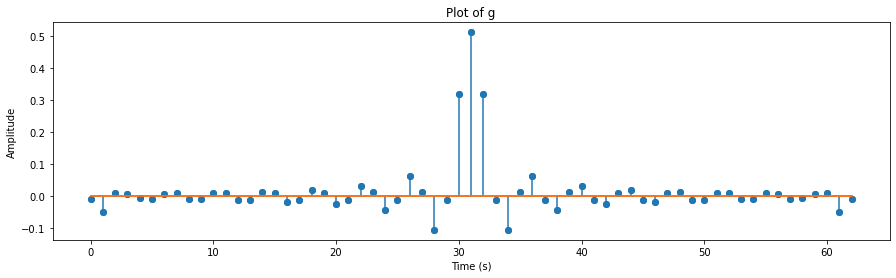

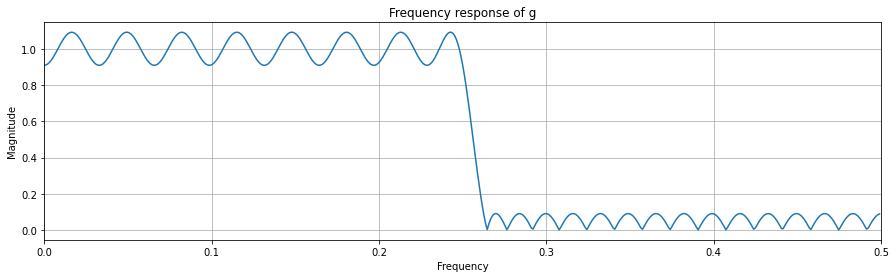

In [3]:
fs = 1
N = 32                  # Size of the filter v
trans_width = 1/80      # Transition width
cutoff = 1/4 
N=32
numtaps = 2*N-1
g = signal.remez(numtaps, [0, cutoff, cutoff+trans_width, 0.5], [1, 0], Hz=fs)
nu, G = signal.freqz(g)

plot_impulse(g, numtaps, "Plot of g")

plot_response(fs, nu, G, "Frequency response of g")

### 1.2

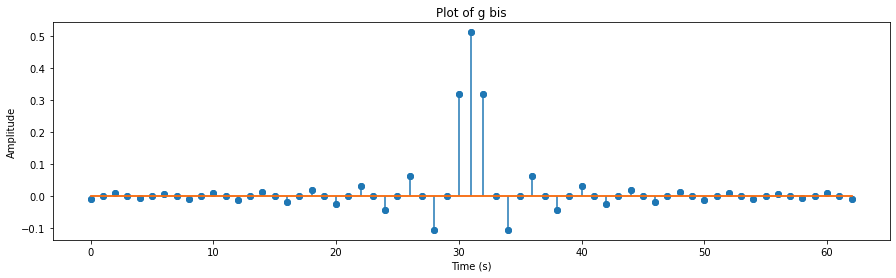

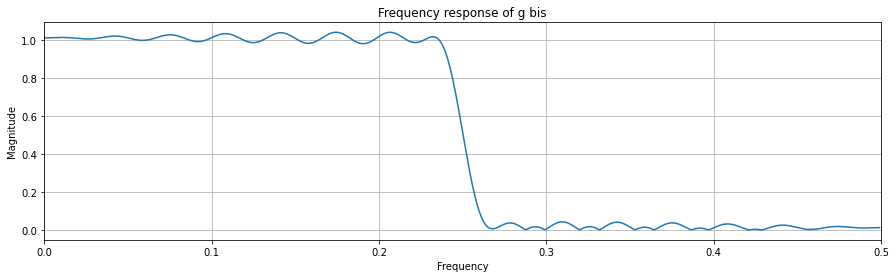

In [4]:

#----- Manually zeroing the coefficients which should be zero -----#
g_bis = deepcopy(g)

for k in range(0, len(g_bis)) :
    if k%2 != 0 and k != len(g_bis)//2 : g_bis[k] = 0

w, G_bis = signal.freqz(g_bis)

plot_impulse(g_bis, numtaps, "Plot of g bis")

plot_response(fs, w, G_bis, "Frequency response of g bis")

### 1.3

$\text{We have that : }$ 
\begin{align}
        G(z) & = c(V(z^2)+z^{N-1}) \\
             & = c \sum_{k=0}^{N-1} v_k z^{-2k} + c z^{-(N-1)} \\
             & = c \sum_{j=0 \\ j \in 2\mathbb{N}}^{2N-2} v_{\frac{j}{2}} z^{-j} + c z^{-(N-1)} \\
\end{align}

$\text{Hence}$

$$ (\forall n \in [0, 2N-1]), g(n) = 
\begin{cases}
        c v_{\frac{n}{2}} \space & if \space 2/n \\
        c \space & if \space n = N-1 \\
        0 \space & otherwise \\
\end{cases}$$

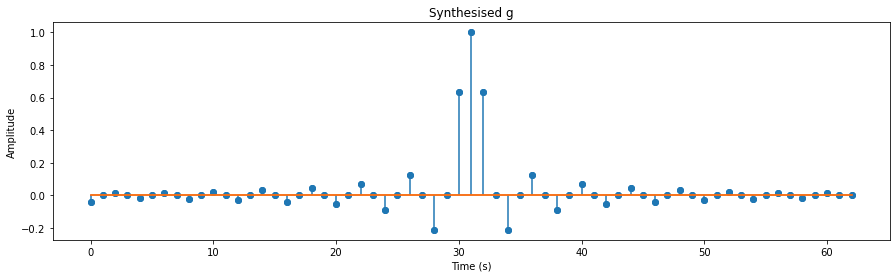

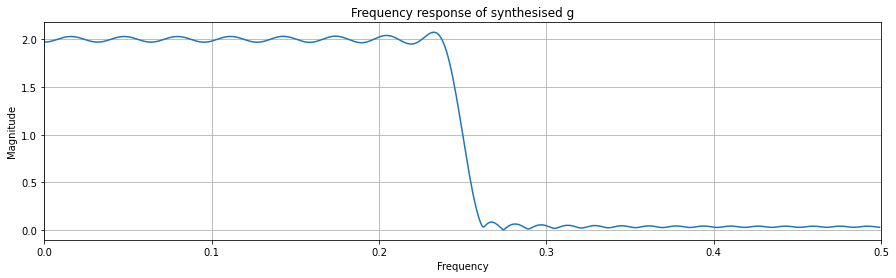

In [5]:

fs = 1
epsilon = 0.02*fs
v_cutoff = 0.5*fs - epsilon
N = 32
v = signal.remez(N, [0, v_cutoff, 0.5, 0.5], [1, 0], Hz=fs)
wv, V = signal.freqz(v)

c=0.5
g_synth = np.zeros(2*N-1)
for n in range(2*N-2):
    if n%2 == 0 : g_synth[n] = v[n//2]
g_synth[N-1] =  1

plot_impulse(g_synth, numtaps, "Synthesised g")
#plot_impulse(v, numtaps//2, "v")
wg, G_synth = signal.freqz(g_synth)
plot_response(fs, wg, G_synth, "Frequency response of synthesised g", absolute = True)

### 1.4

G_R is not real valued. If we look into its real part in the stop-band, we can see that it's not nonnegative.


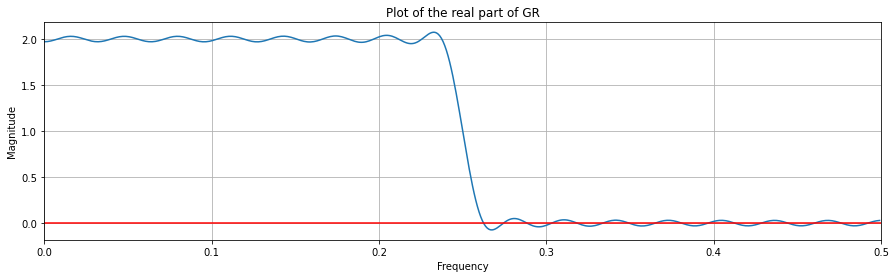

In [6]:
len_fft = 4096 #The size of the Fourier Transform that is yet to apply
frequences, magnitude = signal.freqz(g_synth, worN=len_fft, whole=True) #Magnitude is |G|
frequences = frequences/(2*np.pi)

#-- Computing the filter and its frequency response --#
prod = np.multiply(magnitude, np.exp(1j*2*np.pi*(N-1)*frequences))
gR = np.fft.ifft(prod, len_fft) #We obtain the filter by applying the inverse Fourier Transform
wR, GR = signal.freqz(gR) #Now, we can correctly compute the frequency response of gR

#--Plotting the result --#
plot_response(fs, wR, np.real(GR), "Plot of the real part of GR", absolute = False)
plt.plot(wR, np.zeros(len(wR)), color='r')
print("G_R is not real valued. If we look into its real part in the stop-band, we can see that it's not nonnegative.")

$\text{We can deduce that it's not possible to factorize}$ $G_R$ $\text{in the form}$ $G_R(\nu) = H_0(e^{2i\pi\nu}) \tilde{H_0(e^{2i\pi\nu})}, \text{since } H_0(e^{2i\pi\nu})\tilde{H_0(e^{2i\pi\nu})} \text{ is always positive}.$

### 1.5

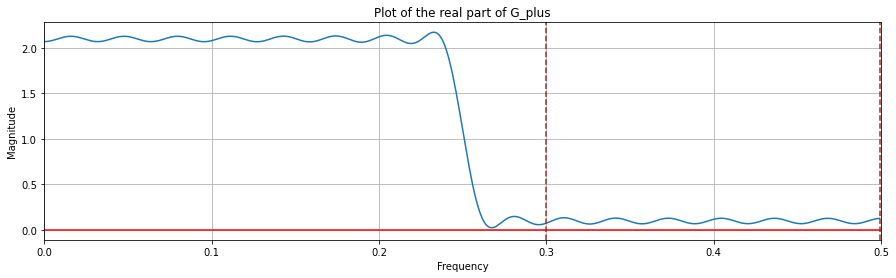

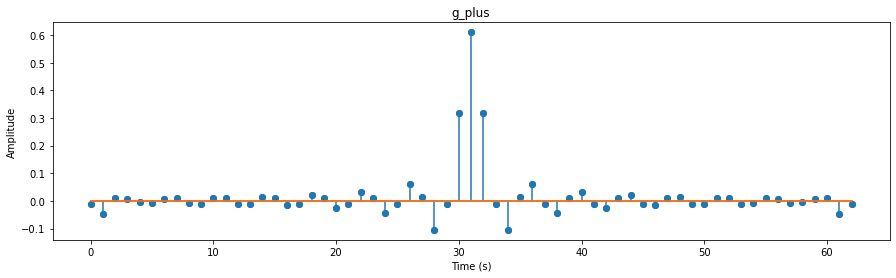

In [7]:
#-- We need first to define the boundaries of the stop-band --#
start = np.where(frequences > 0.3)[0][0]
end = np.where(frequences > 0.5)[0][0]
epsilon = max(np.abs(np.real(magnitude))[start:end]) + 0.05 # Strictly larger the maxium magnitude in the stop-band

#-- Computing the frequency response G_plus as specified --#
G_plus = GR + epsilon
plot_response(fs, wR, np.real(G_plus), "Plot of the real part of G_plus", absolute = False)
plt.plot(wR, np.zeros(len(wR)), color='r')
plt.axvline(0.3, color='brown', linestyle='--')
plt.axvline(0.499, color='brown', linestyle ='--')

#-- Computing the filter g_plus --#
g_plus = g + np.array((N-1)*[0] + [epsilon] + (N-1)*[0])
plot_impulse(g_plus, 2*N-1, "g_plus")

### 1.6

The algorithm stopped after :  202 iterations.


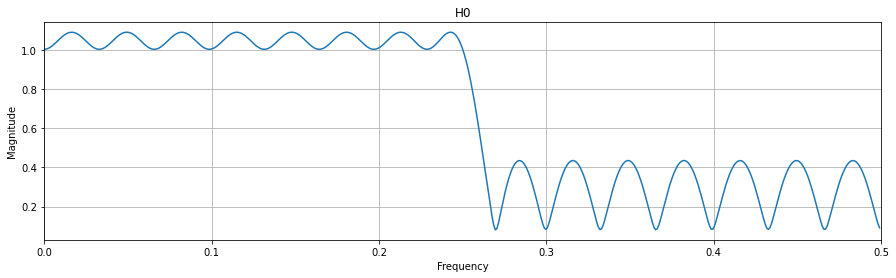

In [24]:
e = 1E-15 #Since it is an iterative algorithm, we need to compute the solution with some error
h0 = np.array([1] + (N-1)*[0]) #initialization of h0 as specified in the practical works
first_column = np.array((N-1)*[0] + [h0[0]]) #Basically, just a transpose of the actual h0
g_util = g_plus[:N] #taking the first N samples of g_plus
A = linalg.hankel(first_column, h0) 
error = np.linalg.norm(A.dot(h0) - g_util) #Computing the error commited in this initialization

cpt = 0
while error > e :
    h0 = np.linalg.inv(A).dot(g_util) 
    h0 *= np.sqrt(g_util[N-1])/np.linalg.norm(h0) #Correctly renormalizing h0
    first_column = np.array((N-1)*[0] + [h0[0]])
    A = linalg.hankel(first_column, h0)
    error = np.linalg.norm(A.dot(h0) - g_util)
    cpt+=1

print("The algorithm stopped after : ", cpt, "iterations.")
wh0, H0 = signal.freqz(h0)
plot_response(fs, wh0, H0, "H0", absolute=True)

### 1.7

$\text{We have that the} \textit{conjugate quadrature filters} \text{condition can be written as : } H_1(z) = -z^{-(N-1)} \tilde{H_0(-z)}$

$\text{Hence :}$

\begin{align}
        H_1(z) & = -z^{-(N-1)} \sum_{k=0}^{N-1} h_0(k)^{*} z^k \\
               & = \sum_{k=0}^{N-1} -h_0(k)^{*} (-z)^{N-1+k} \\
               & = \sum_{n=0}^{N-1} -h_0(n-N+1)^{*} (-z)^{-n} \space \space (with n = N-1+k) \\
        H_1(z) & = \sum_{n=0}^{N-1} \underbrace{\left ((-1)^{n+1} h_0(n-N+1)^{*} \right)}_{h_1(n)} z^{-n} \\
\end{align}

$\text{Therefore, we take } \space (\forall n \in [0, N-1]), \space
\begin{cases}
        h_1(n) = (-1)^{n+1} h_0(n-N+1)^{*} \\
        f_0(n) = h_0(n-N+1) & (similarly) \\
        f_1(n) = h_1(n-N+1) & \\
\end{cases}$

In [23]:
#----- Specifying the filters as above -----#
f0 = [h0[n-N+1] for n in range(N)]
h1 = [((-1)**(n+1))*h0[n-N+1] for n in range(N)]
f1 = [h1[n-N+1] for n in range(N)]

### 1.8

_wave_params(nchannels=1, sampwidth=2, framerate=22050, nframes=330750, comptype='NONE', compname='not compressed')


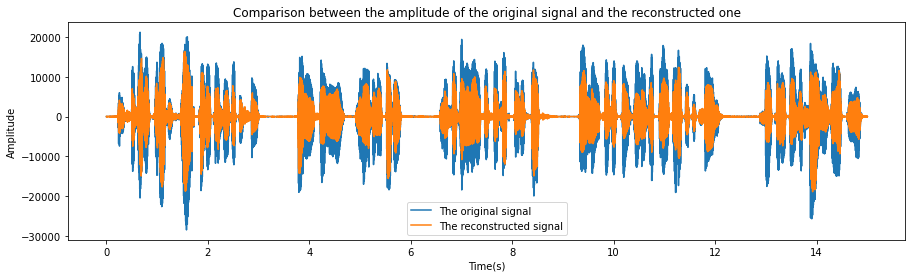

In [63]:
x = get_data("homme3.wav")
s0 = np.convolve(x, h0)
s0_hat = np.convolve(s0, f0)
s1 = np.convolve(x, h1) 
s1_hat = np.convolve(s1, f1) 
x_hat = s0_hat + s1_hat

times_x = np.linspace(0, len(x)/Fs, len(x))
times_reconstructed = np.linspace(0, len(x_hat)/Fs, len(x_hat))

fig = plt.figure(figsize = (15, 4))
plt.plot(times_x, x, label='The original signal')
plt.plot(times_reconstructed, x_hat, label='The reconstructed signal')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.title("Comparison between the amplitude of the original signal and the reconstructed one")
plt.legend()

In [62]:
#----- Listen to the reconstructed signal to verify the perfect reconstruction -----#
play = False
if play :
    print("Listening to x_hat")
    write('Reconstructed_homme3.wav', Fs, np.array(np.real(x_hat), dtype=np.int16))
    data_path = os.getcwd()
    filename = 'Reconstructed_homme3.wav'
    sound = os.path.join(data_path, filename) 
    wavefile = load_sound(sound)
    play_sound(sound)

print("We have perfect reconstruction indeed.")

Listening to x_hat
We have perfect reconstruction indeed.
